| ![EEW logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/main/Jupyter%20instructions/eew.jpg?raw=true) | ![EDGI logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/main/Jupyter%20instructions/edgi.png?raw=true) |
|---|---|


#### This notebook is licensed under GPL 3.0.
#### The notebook was collaboratively authored by the Environmental Data & Governance Initiative (EDGI) following [our authorship protocol](https://docs.google.com/document/d/1CtDN5ZZ4Zv70fHiBTmWkDJ9mswEipX6eCYrwicP66Xw/)
#### For more information about this project, visit [our website](https://www.environmentalenforcementwatch.org/)

## How to Run
![Instructions for running a Jupyter Notebook](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/main/overall_instructions.png?raw=true)

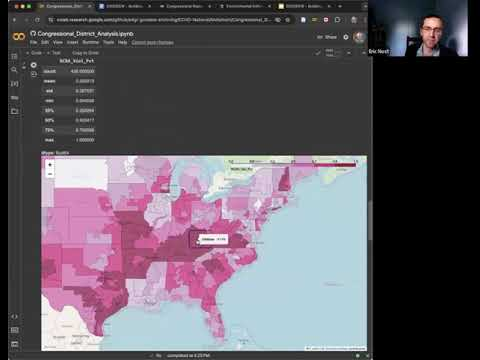

In [1]:
# @title Watch a demo of this notebook { display-mode: "form" }
from IPython.display import YouTubeVideo
YouTubeVideo('GWtNu7_dD3w')

In [ ]:
# @title ## Load data { display-mode: "form" }
# @markdown We created report cards on the enforcement of and compliance with environmental protection laws like the Clean Air Act for each Congressional District and state: https://environmentalenforcementwatch.org/data/congress/
# @markdown <br></br> Here, we analyze nationwide trends over time in inspections under, violations of, and penalties issued under the Clean Air, Clean Water, and Resource Conservation and Recovery Acts. We'll look at recent trends (e.g. the Biden vs. Trump administrations) as well as the longer term (20+ years).
# @markdown <br></br> First, we load in the data and code behind the report cards.

!pip install ECHO_modules &>/dev/null; # Load helper code we wrote
from ECHO_modules.get_data import get_echo_data
import sqlite3, pandas
import requests, zipfile, io

!git clone https://github.com/edgi-govdata-archiving/EEW-ReportCard-Data.git &>/dev/null; # Load helper code for our report card analysis
%mv EEW-ReportCard-Data/AllPrograms*.py .
%mv EEW-ReportCard-Data/Region.py .

r = requests.get('https://github.com/edgi-govdata-archiving/ECHO-National/raw/main/region_cds.zip') # Load data from our report card analysis
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

print("Done!")

Done!


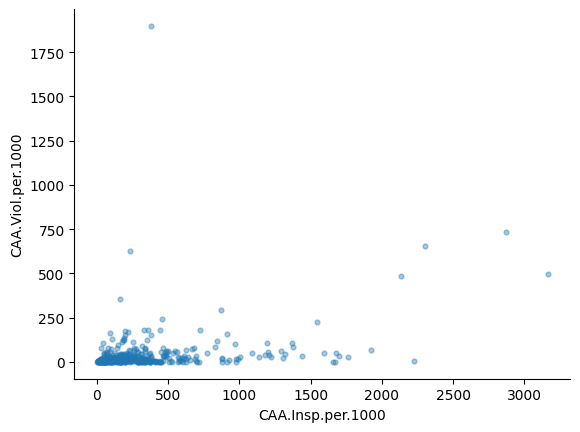

In [ ]:
# @title ## Get the statistics per 1000 facilities for each district (2019-2023) { display-mode: "form" }
# @markdown For CAA, CWA and RCRA EPA programs, we have calculated violations, inspections and enforcement actions per 1000 facilities for each district.
# @markdown <br></br> To give you a sense of what the data are about, we'll show a scatter plot of Clean Air Act inspections per 100 facilities (x axis) compared to Clean Air Act violations per 1000 facilities (y axis).
# @markdown Each dot represents a Congressional District and the rate of violations since 2001 and rate of inspections since then.
# @markdown This gives us a crude sense of how inspections turn into violations - or not.

import pandas
con = sqlite3.connect('region_cds.db')
cur = con.cursor()
districts = pandas.read_sql_query("SELECT * FROM 'cd_per_1000'", con)
con.close()

from matplotlib import pyplot as plt
districts.plot(kind='scatter', y='CAA.Viol.per.1000', x='CAA.Insp.per.1000', s=12, alpha=.4)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# @title ## Get spatial data for mapping { display-mode: "form" }
# @markdown The scatterplot isn't necessarily the most intuitive way to visualize this information.
# @markdown Instead, we'll map it, district by district. First, though, we need to load some spatial data.

import geopandas, folium
cds = geopandas.read_file('https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_cd118_20m.zip')

from ECHO_modules.geographies import fips
fips = {v: k for k, v in fips.items()} # inverse fips lookup
cds['STATEFP'] = cds['STATEFP'].astype(str).map(fips) # map the lookup
cds["CD.State"] = cds["STATEFP"] + "-" + cds["CD118FP"].astype(str)

m = folium.Map()

cd_layer = folium.GeoJson(
  data = cds,
  tooltip=folium.GeoJsonTooltip(
    fields=["CD.State"],
    aliases=["Congressional District"]
  )
).add_to(m)

bounds = m.get_bounds()
m.fit_bounds(bounds)

m

In [ ]:
#@title ## Select a program + violations, inspections or enforcement actions (2019-2023) and map the data { display-mode: "form", run: "auto" }
# @markdown Note: "Pct" stands for percentile. Calculated on a 0-1 scale, it tells us how the rate of violations, inspections per violation, and enforcement actions per violation under the specified act for the Congressional District compares with all other Districts.
# @markdown <br></br> So, for instance, a CAA_Insp_Pct score of .88 means the Distrct has a higher rate of inspections per violation than 88% of all Districts. This suggests strong compliance and/or enforcement - there are lots of inspections being done, relative to violations reported.
Selection = 'RCRA_Viol_Pct' # @param ['CAA.Insp.per.1000', 'CAA.Viol.per.1000', 'CAA.Enf.per.1000', 'CWA.Insp.per.1000', 'CWA.Viol.per.1000', 'CWA.Enf.per.1000', 'RCRA.Insp.per.1000', 'RCRA.Viol.per.1000', 'RCRA.Enf.per.1000', 'CAA_Insp_Pct', 'CAA_Viol_Pct', 'CAA_Enf_Pct', 'CWA_Insp_Pct', 'CWA_Viol_Pct', 'CWA_Enf_Pct', 'RCRA_Insp_Pct', 'RCRA_Viol_Pct', 'RCRA_Enf_Pct']

from ECHO_modules.utilities import choropleth

to_map = pandas.merge(cds, districts, on="CD.State")
to_map["CDState"] = to_map["CD.State"] # Folium doesn't like dot notation due to Leaflet

display(to_map[Selection].describe())

choropleth(polygons=to_map, attribute=Selection, key_id="CDState", legend_name=Selection)

,RCRA_Viol_Pct
count,435.000000
mean,0.503213
std,0.287537
min,0.004556
25%,0.256264
50%,0.503417
75%,0.750569
max,1.000000


<Axes: title={'center': 'Amount of Penalties Reported under RCRA'}, xlabel='year'>

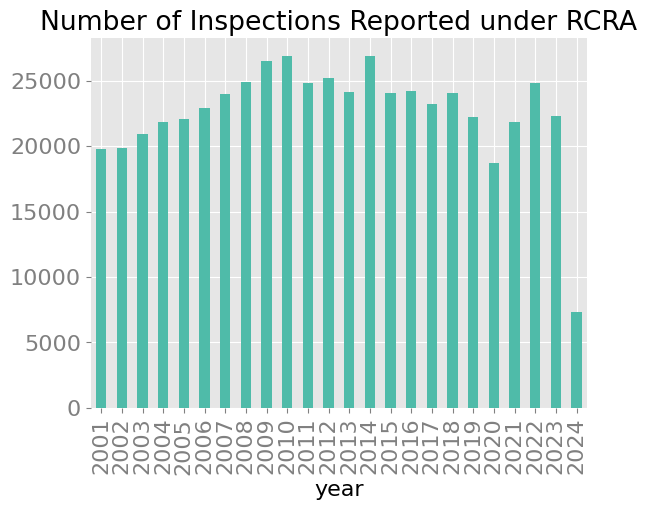

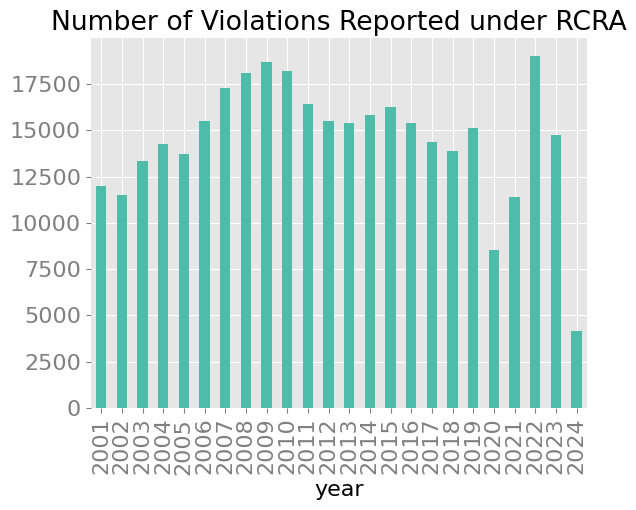

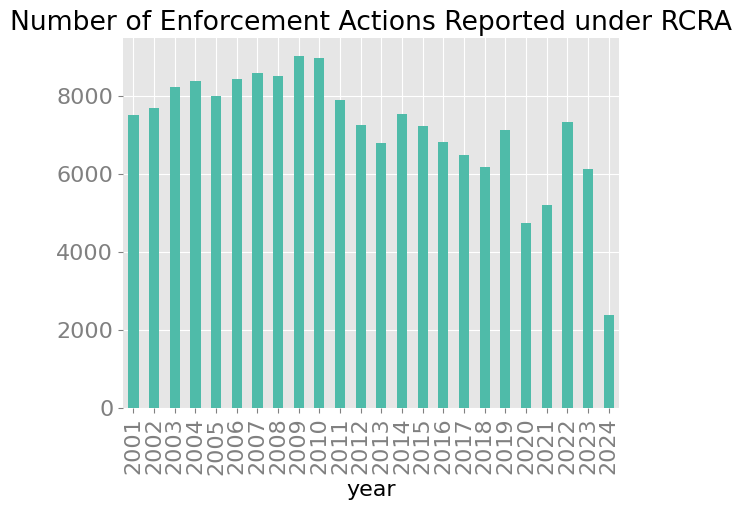

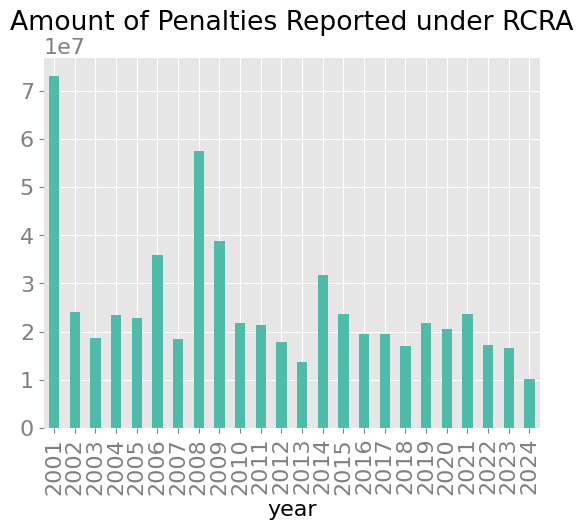

In [ ]:
#@title Nationwide trends since 2001 - total number of violations, inspections, and enforcement actions per administration, for a selected program { display-mode: "form", run: "auto" }

con = sqlite3.connect('region_cds.db')
cur = con.cursor()
inspections = pandas.read_sql_query("SELECT * FROM 'inspections'", con)
violations = pandas.read_sql_query("SELECT * FROM 'violations'", con)
enforcements = pandas.read_sql_query("SELECT * FROM 'enforcements'", con)
con.close()

Selection = 'RCRA' # @param ['CAA', 'CWA', 'RCRA']

filtered_inspections = inspections[inspections['program']==Selection].groupby(by="year")[["count"]].sum()
filtered_inspections.plot.bar(legend=False, title="Number of Inspections Reported under " + Selection)

filtered_violations = violations[violations['program']==Selection].groupby(by="year")[["count"]].sum()
filtered_violations.plot.bar(legend=False, title="Number of Violations Reported under " + Selection)

filtered_eas = enforcements[enforcements['program']==Selection].groupby(by="year")[["count"]].sum()
filtered_eas.plot.bar(legend=False, title="Number of Enforcement Actions Reported under " + Selection)

filtered_penalties = enforcements[enforcements['program']==Selection].groupby(by="year")[["amount"]].sum()
filtered_penalties.plot.bar(legend=False, title="Amount of Penalties Reported under " + Selection)

In [ ]:
# @title Map different metrics { display-mode: "form", run: "auto" }
import warnings
warnings.filterwarnings("ignore")

# Select a program
Program = 'RCRA' # @param ['CAA', 'CWA', 'RCRA']

# Select a dimension - inspections, violations, or enforcement actions
Dimension = 'Violations' # @param ['Inspections', 'Violations', 'Enforcement Actions']
dimensions = {"Inspections": inspections, "Violations": violations, "Enforcement Actions": enforcements}
this_dimension = dimensions[Dimension]

# Calculate different metrics
longterm_average = this_dimension[this_dimension["program"]==Program].groupby(by="region_id")[["count"]].mean().reset_index() # Longterm average for each Congressional District

lt_compare = this_dimension[(this_dimension["program"]==Program) & (this_dimension["year"]==2023)].merge(longterm_average, on="region_id")
lt_compare_under = lt_compare[lt_compare["count_x"]<lt_compare["count_y"]] # Places where x are under the longterm (2001-2023) average
lt_compare_above = lt_compare[lt_compare["count_x"]>lt_compare["count_y"]] # Places where x are above the longterm (2001-2023) average
lt_compare_under.rename(columns={"count_y": "count"}, inplace=True)
lt_compare_above.rename(columns={"count_y": "count"}, inplace=True)

# Select a metric
metrics = {"Annual average # of this dimension": longterm_average,
          "Places where this dimension was UNDER its local longterm (2001-2023) average in 2023": lt_compare_under,
          "Places where this dimension was ABOVE its local longterm (2001-2023) average in 2023": lt_compare_above,
}
Metric = "Places where this dimension was UNDER its local longterm (2001-2023) average in 2023" # @param ["Annual average # of this dimension", "Places where this dimension was UNDER its local longterm (2001-2023) average in 2023", "Places where this dimension was ABOVE its local longterm (2001-2023) average in 2023"]

# Process and display results
this_result = metrics[Metric]

from Region import Region
lookup = {}
for district in cds.iterrows():
  state = district[1]["STATEFP"]
  cd = district[1]["CD118FP"]
  this = Region(type="Congressional District", value=cd, state=state, db="region_cds.db", programs=Program, base_year=2023)
  lookup[this.region_id] = district[1]["CD.State"]

this_result["CD.State"] = this_result["region_id"].map(lookup)
merged = cds.merge(this_result, on="CD.State")
merged["CDState"] = merged["CD.State"]
choropleth(merged,"count", "CDState")